In [1]:
import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import cv2
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report

from tensorflow.keras.layers import concatenate
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.metrics import CategoricalAccuracy
from keras.regularizers import l2
from tensorflow.keras.applications.inception_v3 import InceptionV3

pd.set_option('display.max_columns', None)

2022-11-14 18:01:18.326660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [68]:
train_df = pd.read_csv('/twitter_data_train_multiclass.csv')
test_df = pd.read_csv('data/twitter_data_test_multiclass.csv')

In [69]:
scaler = MinMaxScaler() 
train_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']] = scaler.fit_transform(train_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']])
test_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']] = scaler.transform(test_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']])

In [ ]:
#ANN subset

In [71]:
to_drop = ['Unnamed: 0', 'screen_name', 'url', 'profile_image_url', 'description',
           'id', 'name', 'account_type', 'tweets_list', 'tweets_list_processed',
          'description_processed', 'protected', 'verified', 'account_type_multi', 
          'profile_use_background_image', 'profile_background_tile']

x_train, y_train = train_df.drop(to_drop, axis=1), train_df['account_type_multi']
x_test, y_test = test_df.drop(to_drop, axis=1), test_df['account_type_multi']

In [72]:
x_train = x_train.drop(x_train.iloc[:, 8:20].columns, axis=1)
x_test = x_test.drop(x_test.iloc[:, 8:20].columns, axis=1)
x_train = x_train.drop(x_train.iloc[:, -2:].columns , axis=1)
x_test = x_test.drop(x_test.iloc[:, -2:].columns, axis=1)

In [73]:
x_train.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,tweets_0,tweets_1,tweets_2,tweets_3,tweets_4,tweets_5,tweets_6,tweets_7,tweets_8,tweets_9,tweets_10,tweets_11,tweets_12,tweets_13,tweets_14,tweets_15,tweets_16,tweets_17,tweets_18,tweets_19,tweets_20,tweets_21,tweets_22,tweets_23,tweets_24,tweets_25,tweets_26,tweets_27,tweets_28,tweets_29,tweets_30,tweets_31,tweets_32,tweets_33,tweets_34,tweets_35,tweets_36,tweets_37,tweets_38,tweets_39,tweets_40,tweets_41,tweets_42,tweets_43,tweets_44,tweets_45,tweets_46,tweets_47,tweets_48,tweets_49,tweets_50,tweets_51,tweets_52,tweets_53,tweets_54,tweets_55,tweets_56,tweets_57,tweets_58,tweets_59,tweets_60,tweets_61,tweets_62,tweets_63,tweets_64,tweets_65,tweets_66,tweets_67,tweets_68,tweets_69,tweets_70,tweets_71,tweets_72,tweets_73,tweets_74,tweets_75,tweets_76,tweets_77,tweets_78,tweets_79,tweets_80,tweets_81,tweets_82,tweets_83,tweets_84,tweets_85,tweets_86,tweets_87,tweets_88,tweets_89,tweets_90,tweets_91,tweets_92,tweets_93,tweets_94,tweets_95,tweets_96,tweets_97,tweets_98,tweets_99,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,description_10,description_11,description_12,description_13,description_14,description_15,description_16,description_17,description_18,description_19,description_20,description_21,description_22,description_23,description_24,description_25,description_26,description_27,description_28,description_29,description_30,description_31,description_32,description_33,description_34,description_35,description_36,description_37,description_38,description_39,description_40,description_41,description_42,description_43,description_44,description_45,description_46,description_47,description_48,description_49,description_50,description_51,description_52,description_53,description_54,description_55,description_56,description_57,description_58,description_59,description_60,description_61,description_62,description_63,description_64,description_65,description_66,description_67,description_68,description_69,description_70,description_71,description_72,description_73,description_74,description_75,description_76,description_77,description_78,description_79,description_80,description_81,description_82,description_83,description_84,description_85,description_86,description_87,description_88,description_89,description_90,description_91,description_92,description_93,description_94,description_95,description_96,description_97,description_98,description_99
0,0.000240,0.000019,0.000429,0.000049,0.0,0.0,0.0,0.0,0.091977,0.034554,0.000000,0.059238,0.000000,0.000000,0.000000,0.056452,0.048987,0.058207,0.11607,0.125471,0.0,0.000000,0.151018,0.000000,0.000000,0.058498,0.15312,0.118353,0.439767,0.000000,0.200249,0.0,0.000000,0.178702,0.030877,0.000000,0.000000,0.000000,0.000000,0.0,0.030396,0.0,0.0,0.386811,0.028850,0.0,0.111074,0.000000,0.069019,0.071754,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.031558,0.000000,0.000000,0.000000,0.0,0.000000,0.063091,0.000000,0.000000,0.161387,0.059978,0.000000,0.294536,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.083316,0.000000,0.0,0.000000,0.136500,0.0,0.000000,0.114215,0.374189,0.000000,0.0,0.000000,0.000000,0.0,0.029388,0.000000,0.177164,0.180592,0.000000,0.267742,0.0,0.091636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000052,0.000007,0.002113,0.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.213376,0.000000,0.000000,0.000000,0.000000,0.

In [74]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=69)

In [75]:
ann_model = Sequential()
ann_model.add(Dense(64, activation = 'relu', input_dim = 208))
ann_model.add(Dropout(.1))
ann_model.add(Dense(128, activation='relu'))
ann_model.add(Dense(6, activation='softmax'))

ann_model.summary()
# configure the model
ann_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                13376     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 128)               8320      
                                                                 
 dense_22 (Dense)            (None, 6)                 774       
                                                                 
Total params: 22,470
Trainable params: 22,470
Non-trainable params: 0
_________________________________________________________________


In [76]:
start_time = time.time()
history = ann_model.fit(x_train, y_train, epochs=20, batch_size=50, validation_data=(x_val, y_val))
time_taken = time.time() - start_time
print("Total time taken for the program execution", time_taken) # seconds

score = ann_model.evaluate(x_train, y_train, verbose=0)
print(f'Train loss: {score[0]} / Train accuracy: {score[1]}')

score = ann_model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/20
161/161 [==============================] - 1s 4ms/step - loss: 0.6408 - accuracy: 0.8210 - val_loss: 0.2898 - val_accuracy: 0.8998
Epoch 2/20
161/161 [==============================] - 0s 2ms/step - loss: 0.1964 - accuracy: 0.9331 - val_loss: 0.2154 - val_accuracy: 0.9139
Epoch 3/20
161/161 [==============================] - 0s 2ms/step - loss: 0.1598 - accuracy: 0.9426 - val_loss: 0.1919 - val_accuracy: 0.9330
Epoch 4/20
161/161 [==============================] - 0s 2ms/step - loss: 0.1433 - accuracy: 0.9486 - val_loss: 0.1887 - val_accuracy: 0.9506
Epoch 5/20
161/161 [==============================] - 0s 2ms/step - loss: 0.1291 - accuracy: 0.9549 - val_loss: 0.1787 - val_accuracy: 0.9358
Epoch 6/20
161/161 [==============================] - 0s 2ms/step - loss: 0.1193 - accuracy: 0.9565 - val_loss: 0.1759 - val_accuracy: 0.9428
Epoch 7/20
161/161 [==============================] - 0s 2ms/step - loss: 0.1099 - accuracy: 0.9620 - val_loss: 0.1668 - val_accuracy: 0.9386
Epoch 

In [77]:
pred = ann_model.predict(x_test)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test, pred, digits=5))

53/53 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0    0.93046   0.93947   0.93494       413
           1    0.94255   0.96304   0.95269       460
           2    0.96992   0.93478   0.95203       276
           3    0.98249   0.97490   0.97868       518

    accuracy                        0.95621      1667
   macro avg    0.95636   0.95305   0.95458      1667
weighted avg    0.95650   0.95621   0.95626      1667



## ANN
training a ANN with categorical and numerical attributes

In [83]:
to_drop = ['Unnamed: 0', 'screen_name', 'url', 'profile_image_url', 'description',
           'id', 'name', 'account_type', 'tweets_list', 'tweets_list_processed',
          'description_processed', 'protected', 'verified', 'account_type_multi', 
          'profile_use_background_image', 'profile_background_tile']

x_train, y_train = train_df.drop(to_drop, axis=1), train_df['account_type_multi']
x_test, y_test = test_df.drop(to_drop, axis=1), test_df['account_type_multi']

In [84]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=69)

In [85]:
start_time = time.time()

ann_model = Sequential()
ann_model.add(Dense(64, activation = 'relu', input_dim = 222))
ann_model.add(Dropout(.1))
ann_model.add(Dense(128, activation='relu'))
ann_model.add(Dense(6, activation='softmax'))

ann_model.summary()
# configure the model
ann_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 64)                14272     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 128)               8320      
                                                                 
 dense_28 (Dense)            (None, 6)                 774       
                                                                 
Total params: 23,366
Trainable params: 23,366
Non-trainable params: 0
_________________________________________________________________


In [86]:
start_time = time.time()
history = ann_model.fit(x_train, y_train, epochs=20, batch_size=50, validation_data=(x_val, y_val))
time_taken = time.time() - start_time
print("Total time taken for the program execution", time_taken) # seconds

score = ann_model.evaluate(x_train, y_train, verbose=0)
print(f'Train loss: {score[0]} / Train accuracy: {score[1]}')

score = ann_model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/20
161/161 [==============================] - 1s 4ms/step - loss: 0.5580 - accuracy: 0.8250 - val_loss: 0.2441 - val_accuracy: 0.9358
Epoch 2/20
161/161 [==============================] - 0s 2ms/step - loss: 0.2441 - accuracy: 0.9248 - val_loss: 0.2012 - val_accuracy: 0.9492
Epoch 3/20
161/161 [==============================] - 0s 2ms/step - loss: 0.1615 - accuracy: 0.9539 - val_loss: 0.1680 - val_accuracy: 0.9661
Epoch 4/20
161/161 [==============================] - 0s 2ms/step - loss: 0.1306 - accuracy: 0.9655 - val_loss: 0.1317 - val_accuracy: 0.9732
Epoch 5/20
161/161 [==============================] - 0s 2ms/step - loss: 0.1088 - accuracy: 0.9701 - val_loss: 0.1301 - val_accuracy: 0.9753
Epoch 6/20
161/161 [==============================] - 0s 2ms/step - loss: 0.0827 - accuracy: 0.9765 - val_loss: 0.1092 - val_accuracy: 0.9682
Epoch 7/20
161/161 [==============================] - 0s 2ms/step - loss: 0.0849 - accuracy: 0.9762 - val_loss: 0.1267 - val_accuracy: 0.9760
Epoch 

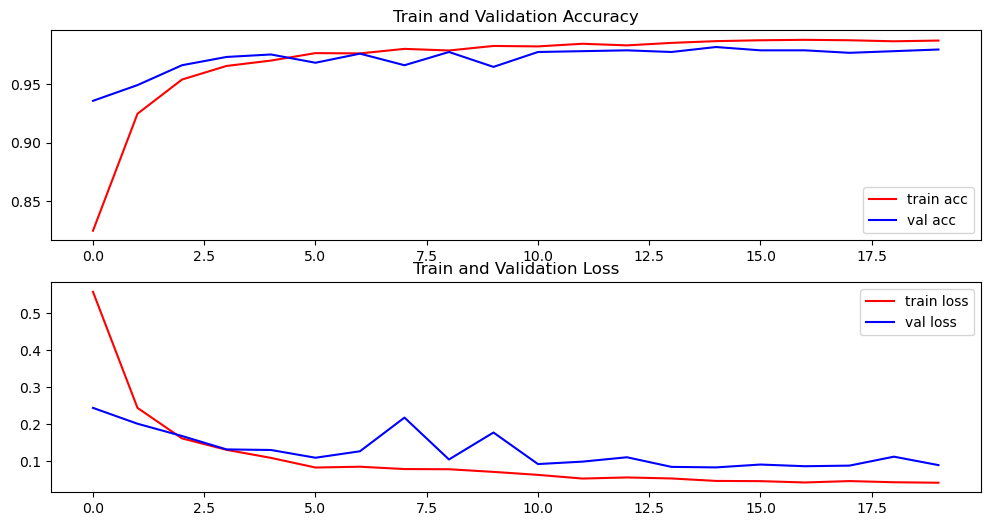

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6), dpi=100)
plt.subplot(2,1,1)
plt.plot(acc, 'r', label='train acc')
plt.plot(val_acc, 'b', label='val acc')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.subplot(2,1,2)
plt.plot(loss, 'r', label='train loss')
plt.plot(val_loss, 'b', label='val loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.show()

In [88]:
pred = ann_model.predict(x_test)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test, pred, digits=5))

53/53 [==============================] - 0s 992us/step
              precision    recall  f1-score   support

           0    0.95238   0.96852   0.96038       413
           1    0.98701   0.99130   0.98915       460
           2    0.97818   0.97464   0.97641       276
           3    0.98824   0.97297   0.98054       518

    accuracy                        0.97720      1667
   macro avg    0.97645   0.97686   0.97662      1667
weighted avg    0.97735   0.97720   0.97724      1667



## CNN
training a CNN using user's profile photos

In [89]:
faces_base = "../new batch profile pics/"

In [90]:
# get all image pathnames from base
# list to store files
res = []
res2 = []

# Iterate directory
for path in os.listdir(faces_base):
    # check if current path is a file
    if os.path.isfile(os.path.join(faces_base, path)):
        res.append(faces_base + path)
        res2.append(path)

### Pre trained CNN: InceptionV3

In [91]:
train_img_dict2 = {}
test_img_dict2 = {}
train_img2 = []
test_img2 = []
for i in range(len(res)):
    pic = res[i]
    id_name = re.match(r"[^\/\\]+(?=\.png|\.jpg)", res2[i]).group(0)
    try:
        img = cv2.imread(pic)
        if img is None:
            print("none")
            continue
        img = cv2.resize(img, (75, 75))
        if int(id_name) in list(train_df['id']):
            train_img_dict2[int(id_name)] = img 
            train_img2.append(img)
        elif int(id_name) in list(test_df['id']):
            test_img_dict2[int(id_name)] = img
            test_img2.append(img)
        #img.close()
    except Exception as e:
        print(e)

none
none
none
none
none
none
none
none
none
none
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
none
none
none
none
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
none
none
libpng warning: iCCP: known incorrect sRGB profile
none
none
none
none
none


In [92]:
train_img_df2 = pd.DataFrame(train_img_dict2.items(), columns = ['id', 'img'])  
test_img_df2 = pd.DataFrame(test_img_dict2.items(), columns = ['id', 'img'])  
train_df_with_img2 = pd.merge(train_img_df2, train_df, on='id')
test_df_with_img2 = pd.merge(test_img_df2, test_df, on='id')

In [93]:
base_model = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(70, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)
model = Model(base_model.input, x)
# configure the model
model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [94]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(np.array(train_img2) / 255.0, train_df_with_img2['account_type_multi'], test_size=0.15)

In [95]:
#es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
start_time = time.time()
inc_history = model.fit(x_train2, y_train2, epochs=20, batch_size=50, validation_data=(x_val2, y_val2))
time_taken = time.time() - start_time
print("Total time taken for the program execution", time_taken) # seconds

Epoch 1/20
161/161 [==============================] - 35s 193ms/step - loss: 1.2554 - accuracy: 0.4530 - val_loss: 1.0318 - val_accuracy: 0.5152
Epoch 2/20
161/161 [==============================] - 30s 186ms/step - loss: 1.0592 - accuracy: 0.5195 - val_loss: 0.9994 - val_accuracy: 0.5272
Epoch 3/20
161/161 [==============================] - 31s 195ms/step - loss: 1.0125 - accuracy: 0.5410 - val_loss: 0.9858 - val_accuracy: 0.5343
Epoch 4/20
161/161 [==============================] - 37s 232ms/step - loss: 0.9721 - accuracy: 0.5673 - val_loss: 0.9675 - val_accuracy: 0.5519
Epoch 5/20
161/161 [==============================] - 33s 203ms/step - loss: 0.9377 - accuracy: 0.5901 - val_loss: 0.9596 - val_accuracy: 0.5527
Epoch 6/20
161/161 [==============================] - 35s 220ms/step - loss: 0.9056 - accuracy: 0.5981 - val_loss: 0.9721 - val_accuracy: 0.5541
Epoch 7/20
161/161 [==============================] - 34s 208ms/step - loss: 0.8772 - accuracy: 0.6178 - val_loss: 0.9658 - val_ac

In [96]:
score = model.evaluate(x_train2, y_train2, verbose=0)
print(f'Train loss: {score[0]} / Train accuracy: {score[1]}')

Train loss: 0.3346036374568939 / Train accuracy: 0.9026824831962585


In [97]:
score = model.evaluate(np.array(test_img2) / 255.0, test_df_with_img2['account_type_multi'], verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.0615887641906738 / Test accuracy: 0.605896532535553


In [98]:
pred = model.predict(np.array(test_img2) / 255.0)
pred = np.argmax(pred,axis=1)

52/52 [==============================] - 22s 125ms/step


In [99]:
print(classification_report(test_df_with_img2['account_type_multi'], pred, digits=5))

              precision    recall  f1-score   support

           0    0.48387   0.47330   0.47853       412
           1    0.51442   0.46522   0.48858       460
           2    0.93506   0.78832   0.85545       274
           3    0.62418   0.74031   0.67730       516

    accuracy                        0.60590      1662
   macro avg    0.63939   0.61679   0.62497      1662
weighted avg    0.61027   0.60590   0.60516      1662



### Self-train CNN

In [44]:
train_img_dict = {}
test_img_dict = {}
train_img = []
test_img = []
for i in range(len(res)):
    pic = res[i]
    id_name = re.match(r"[^\/\\]+(?=\.png|\.jpg)", res2[i]).group(0)
    try:
        img = cv2.imread(pic)
        if img is None:
            print("none")
            continue
        if int(id_name) in list(train_df['id']):
            train_img_dict[int(id_name)] = img 
            train_img.append(img)
        elif int(id_name) in list(test_df['id']):
            test_img_dict[int(id_name)] = img
            test_img.append(img)
        #img.close()
    except Exception as e:
        print(e)

none
none
none
none
none
none
none
none
none
none
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
none
none
none
none
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
none
none
libpng warning: iCCP: known incorrect sRGB profile
none
none
none
none
none


In [348]:
len(train_img_dict)

9430

In [45]:
train_img_df = pd.DataFrame(train_img_dict.items(), columns = ['id', 'img'])  
test_img_df = pd.DataFrame(test_img_dict.items(), columns = ['id', 'img'])  
train_df_with_img = pd.merge(train_img_df, train_df, on='id')
test_df_with_img = pd.merge(test_img_df, test_df, on='id')

In [383]:
kernel_size = (3, 3)
stride_size = (1, 1)
filters = [4, 8, 16]

cnn_model = Sequential()
cnn_model.add(Input(shape=(48, 48, 3)))
for f in filters:
    cnn_model.add(Conv2D(f, kernel_size, strides=stride_size, activation='relu'))
    cnn_model.add(Dropout(0.1))
    cnn_model.add(Conv2D(f, kernel_size, strides=stride_size, activation='relu'))
    cnn_model.add(BatchNormalization(axis = -1))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(6, activation='softmax'))
# configure the model
cnn_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [431]:
kernel_size = (3, 3)
stride_size = (1, 1)
filters = [4, 10, 24]

cnn_model = Sequential()
cnn_model.add(Input(shape=(48, 48, 3)))
for f in filters:
    cnn_model.add(Conv2D(f, kernel_size, strides=stride_size, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    cnn_model.add(Conv2D(f, kernel_size, strides=stride_size, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    cnn_model.add(BatchNormalization(axis = -1))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dropout(0.1))

cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Dense(100, activation='relu'))

cnn_model.add(Dense(6, activation='softmax'))
# configure the model
cnn_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [432]:
x_train, x_val, y_train, y_val = train_test_split(np.array(train_img) / 255.0, train_df_with_img['account_type_multi'], test_size=0.15)

In [433]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
history = cnn_model.fit(x_train, y_train, epochs=100, batch_size=20, validation_data=(x_val, y_val), callbacks = es_callback)

Epoch 1/100
401/401 [==============================] - 17s 38ms/step - loss: 1.7331 - accuracy: 0.4354 - val_loss: 1.8124 - val_accuracy: 0.3880
Epoch 2/100
401/401 [==============================] - 14s 35ms/step - loss: 1.5007 - accuracy: 0.4770 - val_loss: 1.4975 - val_accuracy: 0.4353
Epoch 3/100
401/401 [==============================] - 14s 36ms/step - loss: 1.3867 - accuracy: 0.4957 - val_loss: 1.3613 - val_accuracy: 0.4890
Epoch 4/100
401/401 [==============================] - 14s 36ms/step - loss: 1.3133 - accuracy: 0.4987 - val_loss: 1.3241 - val_accuracy: 0.4905
Epoch 5/100
401/401 [==============================] - 14s 35ms/step - loss: 1.2707 - accuracy: 0.5154 - val_loss: 1.2847 - val_accuracy: 0.4883
Epoch 6/100
401/401 [==============================] - 14s 36ms/step - loss: 1.2424 - accuracy: 0.5188 - val_loss: 1.2548 - val_accuracy: 0.5088
Epoch 7/100
401/401 [==============================] - 14s 36ms/step - loss: 1.2212 - accuracy: 0.5279 - val_loss: 1.2828 - val_ac

In [434]:
score = cnn_model.evaluate(x_train, y_train, verbose=0)
print(f'Train loss: {score[0]} / Train accuracy: {score[1]}')

Train loss: 0.653897225856781 / Train accuracy: 0.8326886892318726


In [435]:
score = cnn_model.evaluate(np.array(test_img) / 255.0, test_df_with_img['account_type_multi'], verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.6942102909088135 / Test accuracy: 0.5391095280647278


## ANN + CNN
train a neural network that combines categorical/numerical attributes with images

In [100]:
x_train, y_train = train_df_with_img2.drop(to_drop, axis=1), train_df_with_img2['account_type_multi']
x_test, y_test = test_df_with_img2.drop(to_drop, axis=1), test_df_with_img2['account_type_multi']

In [101]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)

In [102]:
x_train_img, x_train_attr = np.stack(x_train['img']) / 255.0, x_train.drop('img', axis=1)
x_val_img, x_val_attr = np.stack(x_val['img']) / 255.0, x_val.drop('img', axis=1)
x_test_img, x_test_attr = np.stack(x_test['img']) / 255.0, x_test.drop('img', axis=1)

In [103]:
def create_ann():
    ann_model = Sequential()
    ann_model.add(Dense(64, activation = 'relu', input_dim = 222))
    ann_model.add(Dropout(.1))
    ann_model.add(Dense(128, activation='relu'))
    return ann_model

In [104]:
def create_cnn():    
    base_model = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(70, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation='softmax')(x)
    cnn_model = Model(base_model.input, x)
    return cnn_model

In [105]:
ann_model = create_ann()
cnn_model = create_cnn()
combined_input = concatenate([ann_model.output, cnn_model.output])
x = Dense(50, activation="relu")(combined_input)
x = Dense(6, activation="softmax")(x)
combined_model = Model(inputs=[ann_model.input, cnn_model.input], outputs=x)
combined_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [106]:
#es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
start_time = time.time()
combined_model.fit(
	x=[x_train_attr, x_train_img], y=y_train,
	validation_data=([x_val_attr, x_val_img], y_val),
	epochs=20, batch_size=50)
time_taken = time.time() - start_time
print("Total time taken for the program execution", time_taken) # seconds

Epoch 1/20
161/161 [==============================] - 38s 202ms/step - loss: 0.5380 - accuracy: 0.8196 - val_loss: 0.2438 - val_accuracy: 0.9223
Epoch 2/20
161/161 [==============================] - 39s 244ms/step - loss: 0.2178 - accuracy: 0.9329 - val_loss: 0.1329 - val_accuracy: 0.9583
Epoch 3/20
161/161 [==============================] - 45s 278ms/step - loss: 0.1412 - accuracy: 0.9592 - val_loss: 0.0962 - val_accuracy: 0.9654
Epoch 4/20
161/161 [==============================] - 36s 224ms/step - loss: 0.1096 - accuracy: 0.9692 - val_loss: 0.1078 - val_accuracy: 0.9604
Epoch 5/20
161/161 [==============================] - 37s 231ms/step - loss: 0.0967 - accuracy: 0.9735 - val_loss: 0.0969 - val_accuracy: 0.9675
Epoch 6/20
161/161 [==============================] - 39s 242ms/step - loss: 0.0884 - accuracy: 0.9752 - val_loss: 0.0848 - val_accuracy: 0.9731
Epoch 7/20
161/161 [==============================] - 39s 244ms/step - loss: 0.0787 - accuracy: 0.9784 - val_loss: 0.0723 - val_ac

In [107]:
score = combined_model.evaluate([x_train_attr, x_train_img], y_train, verbose=0)
print(f'Train loss: {score[0]} / Train accuracy: {score[1]}')

Train loss: 0.026401977986097336 / Train accuracy: 0.9920149445533752


In [108]:
score = combined_model.evaluate([x_test_attr, x_test_img], y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.1009983941912651 / Test accuracy: 0.9753309488296509


In [109]:
pred = combined_model.predict([x_test_attr, x_test_img])
pred = np.argmax(pred,axis=1)

52/52 [==============================] - 7s 103ms/step


In [110]:
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.94159   0.97816   0.95952       412
           1    0.98911   0.98696   0.98803       460
           2    0.98134   0.95985   0.97048       274
           3    0.98817   0.97093   0.97947       516

    accuracy                        0.97533      1662
   macro avg    0.97505   0.97397   0.97438      1662
weighted avg    0.97576   0.97533   0.97541      1662

